# Neural process

In [2]:
import os
import pandas as pd
import numpy as onp

import jax
import jax.numpy as np
import jax.scipy as sp
import jax.random as random
import haiku as hk
import numpyro.distributions as dist

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import palettes

from pax import train
from pax.covariance_functions import covariance, exponentiated_quadratic
from pax.models import NP

sns.set_style(
    "ticks",
    {'font.family':'serif',
     'font.serif':'Times New Roman'}
)
palettes.set_theme()

In [27]:
random.normal(random.PRNGKey(1), shape=(10,))

DeviceArray([ 0.6908049 , -0.48744112, -1.155789  ,  0.12108456,
             -0.1959844 , -0.50787675,  0.9156864 ,  1.7096797 ,
             -0.36749426,  0.14315681], dtype=float32)

In [26]:
key, sample_key1, sample_key2 = random.split(key, 3)
print(key)

[3699749278 1140115442]


In [66]:
def sin_data(key, batch_size = 10, num_observations = 100):
    key, sample_key = random.split(key, 2)
    x = np.linspace(-np.pi, np.pi, num_observations).reshape((num_observations, 1))
    ys = []
    fs = []
    for i in range(batch_size):            
        key, sample_key1, sample_key2, sample_key3 = random.split(key, 4)
        a = 2 * random.uniform(sample_key1) - 1            
        b = random.uniform(sample_key2) - 0.5        
        f = a * np.sin(x - b) 
        y = f + random.normal(sample_key3, shape=(num_observations, 1)) * 0.1
        fs.append(f.reshape((1, num_observations, 1)))
        ys.append(y.reshape((1, num_observations, 1)))
    
    x_target = np.tile(x, [batch_size, 1, 1])
    y_target = np.vstack(np.array(ys))
    f_target = np.vstack(np.array(fs))    
    
    return x_target, y_target, f_target

In [67]:
x_target, y_target, f_target = sin_data(key)

In [68]:
x_target = x_target[:1, :, :]
y_target = y_target[:1, :, :]
f_target = f_target[:1, :, :]

In [69]:
context_idxs = np.arange(0, x_target.shape[1], 2)
x_context = x_target[:, context_idxs, :]
y_context = y_target[:, context_idxs, :]

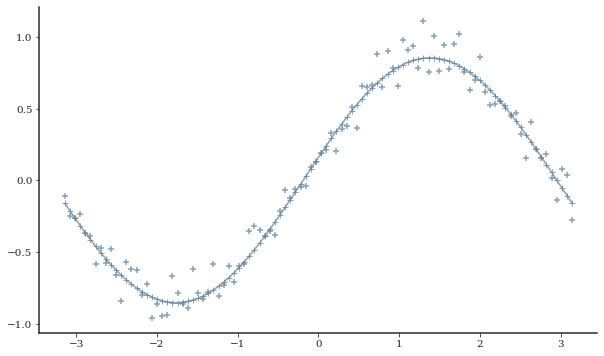

In [70]:
cols = palettes.discrete_sequential_colors(10)

_, ax = plt.subplots(figsize=(10, 6))
for i in range(x_target.shape[0]):
    x = np.squeeze(x_target[i, :, :])
    y = np.squeeze(y_target[i, :, :])
    f = np.squeeze(f_target[i, :, :])
    idxs = np.argsort(x)
    ax.plot(x[idxs], f[idxs], marker="+", color=cols[i], alpha=0.75)
    ax.scatter(x[idxs], y[idxs], marker="+", color=cols[i], alpha=0.75)
plt.show()

In [74]:
def f(**kwargs):
    dim = 50
    np = NP(
        hk.nets.MLP([dim] * 3),  # deterministic encoder
        hk.nets.MLP([dim] * 3),  # latent encoder
        [dim, 2],                # last dimension(s) of latent encoder after aggregation
        hk.nets.MLP([dim] * 2 + [2]), # decoder
    )
    return np(**kwargs)

f  = hk.transform(f)

In [75]:
key, init_key = random.split(key)
params = f.init(init_key, x_context=x_context, y_context=y_context, x_target=x_target)

UnboundLocalError: local variable 'latent_encoder_dim' referenced before assignment

In [73]:
key, train_key = random.split(key)
params, objectives = train(
    f,
    params,
    train_key,
    n_iter=20000,
    x_context=x_context,
    y_context=y_context,
    x_target=x_target,
    y_target=y_target,
)

NameError: name 'params' is not defined

In [94]:
key, apply_key = random.split(key)
posterior_predictive = f.apply(params=params, rng=apply_key, x_context=x_context, y_context=y_context, x_target=x_target)

In [95]:
key, sample_key = random.split(key)
y_target_posterior = posterior_predictive.sample(key=sample_key, sample_shape=(10000,))

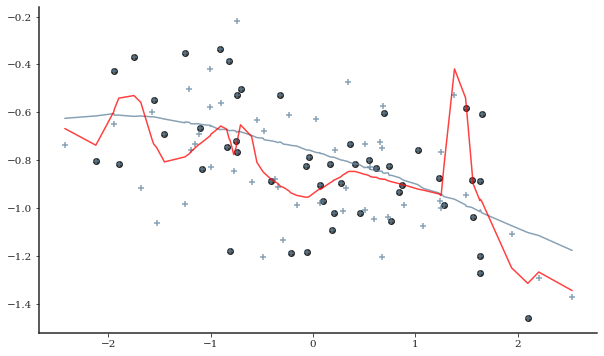

In [96]:
idx = 0
y_star = np.mean(y_target_posterior[:, [idx], :, :], axis=0)

_, ax = plt.subplots(figsize=(10, 6))
xp = np.squeeze(x_target[idx, :, :])
yp = np.squeeze(y_target[idx, :, :])
fp = np.squeeze(f_target[idx, :, :])
yp_star = np.squeeze(y_star[idx, :, :])

idxs = np.argsort(xp)
ax.scatter(x_context, y_context, color="black", alpha=0.75)
ax.plot(xp[idxs], fp[idxs], color=cols[i], alpha=0.75)
ax.scatter(xp[idxs], yp[idxs], marker="+", color=cols[i], alpha=0.75)
ax.plot(xp[idxs], yp_star[idxs], color="red", alpha=0.75)
plt.show()